In [85]:


%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner


import radvel
import radvel.likelihood

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


from radvel.plot import orbit_plots, mcmc_plots

matplotlib.rcParams['font.size'] = 22

In [86]:

rv = pd.read_csv("rvout_TOI5671.dat",header=None,delim_whitespace=True)


rv = rv.drop(rv.index[[5,12,16]])

print(rv)

t = np.array(rv[0])-2457000

vel = np.array(rv[1])
errvel = np.array(rv[2])

               0           1          2            3            4      5
0   2.460042e+06  236.098298  32.443436  1882.336085  1477.518555  210.0
1   2.460042e+06  276.621086  31.503643  1740.092043  1281.006233  242.0
2   2.460042e+06   -6.259502  51.382588  2156.562077  1842.144399  138.0
3   2.460042e+06   53.897957  57.897331  2222.306427  1795.776970  147.0
4   2.460042e+06  121.160048  36.540409  1893.604122  1417.525087  211.0
6   2.460074e+06 -111.844054  21.495063  1314.979623   687.026180  279.0
7   2.460075e+06  233.139018  27.708191  1530.967525   984.131208  294.0
8   2.460075e+06  197.542974  21.690891  1404.120447   819.786210  276.0
9   2.460076e+06   61.185449  35.103784  1836.272072  1302.588377  249.0
10  2.460076e+06    8.493320  25.215836  1528.987613   938.470054  287.0
11  2.460076e+06    0.000000  24.617423  1528.622869   949.482090  294.0
13  2.460157e+06 -162.903928  22.906626  1533.113860  1017.011269  291.0
14  2.460160e+06 -363.356917  24.850000  1463.17098

In [87]:
def plot_results(like):
    fig = pl.figure(figsize=(12,6))
    fig = pl.gcf()
    fig.set_tight_layout(True)
    pl.errorbar(like.x, like.model(t)+like.residuals(),yerr=like.yerr, fmt='o',color='blue',capsize=3)
    #pl.plot(ti, like.model(ti))
    pl.xlabel('BJD - 2457000 [day]')
    pl.ylabel('Relative RV [m/s]')
    pl.title('TOI-5671')
    pl.draw()

In [88]:
from astropy import constants as const


period = 3.3079817
period_err = 0.0006559*3

t0 = 2459685.753346 -2457000
t0_nor = 0.0018235*3 


In [89]:
def initialize_model():
    params = radvel.Parameters(1,basis='per tc secosw sesinw k') # number of planets = 2
    params['per1'] = radvel.Parameter(value=period)
    params['tc1'] = radvel.Parameter(value=t0)
    params['secosw1'] = radvel.Parameter(value=0.05)
    params['sesinw1'] = radvel.Parameter(value=-0.05) 
    params['k1'] = radvel.Parameter(value=182.331836)#amp)
    mod = radvel.model.RVModel(params, time_base=t[0])
    return mod

In [90]:
mod = initialize_model()
mod.params['dvdt'] = radvel.Parameter(value=0.0,vary=False)
mod.params['curv'] = radvel.Parameter(value=0.0,vary=False)



like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = radvel.Parameter(value=-4.056213, vary=True, linear=True)
like.params['jit'] = radvel.Parameter(value=0.129844,vary=True) #np.log(np.abs(np.min(errvel)))



print(like.logprob())

-258.3423330807636


In [91]:


post = radvel.posterior.Posterior(like)


post.priors += [radvel.prior.Gaussian( 'per1', period,period_err)]
post.priors += [radvel.prior.Jeffreys( 'jit',1e-2,1000)] 

post.priors +=[radvel.prior.Gaussian( 'tc1', t0,t0_nor)]




post.priors +=[radvel.prior.HardBounds( 'k1', 0.1,500)]

#post.priors +=[radvel.prior.HardBounds('secosw1', 1e-2,0.75)]
#post.priors +=[radvel.prior.HardBounds('sesinw1', -0.75,-1e-2)]

post.priors += [radvel.prior.EccentricityPrior(1)]

alpha, beta = 0.867,3.03 
def BetaPrior(param_list):
    ecc = (param_list[0]**2)+(param_list[1]**2)
    if ecc <=0. or 1<= ecc:
        return -np.inf
    else:
        return ((1.-ecc)**(beta-1))*(ecc**(alpha-1))

post.priors += [radvel.prior.UserDefinedPrior(['secosw1','sesinw1'], BetaPrior, "Beta Prior on")]

print(post)
print(like.logprob())

parameter                     value      vary
per1                        3.30798       True
tc1                         2685.75       True
secosw1                        0.05       True
sesinw1                       -0.05       True
k1                          182.332       True
dvdt                              0      False
curv                              0      False
gamma                      -4.05621       True
jit                        0.129844       True
tp1                         2684.52           
e1                            0.005           
w1                        -0.785398           

Priors
------
Gaussian prior on per1, mu=3.3079817, sigma=0.0019676999999999997
Jeffrey's prior on jit, min=0.01, max=1000
Gaussian prior on tc1, mu=2685.7533459998667, sigma=0.0054705
Bounded prior on k1, min=0.1, max=500
e1 constrained to be < 0.99
User-defined prior on ['secosw1', 'sesinw1']

-253.107503108292


In [92]:
print(post.get_vary_params())

[ 3.30798170e+00  2.68575335e+03  5.00000000e-02 -5.00000000e-02
  1.82331836e+02 -4.05621300e+00  1.29844000e-01]


-253.107503108292
-181.17918835557342
parameter                     value      vary
per1                        3.30798       True
tc1                         2685.75       True
secosw1                        0.05       True
sesinw1                       -0.05       True
k1                          182.332       True
dvdt                              0      False
curv                              0      False
gamma                      -4.05621       True
jit                        0.129844       True
tp1                         2684.52           
e1                            0.005           
w1                        -0.785398           



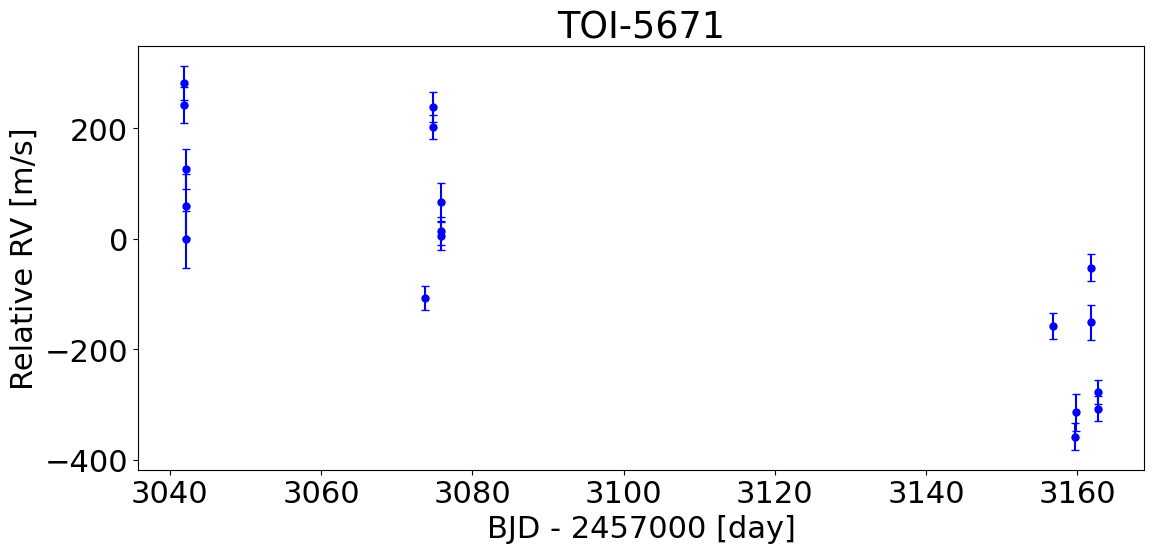

In [93]:
print(like.logprob())
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Nelder-Mead',            # Powell also works
    )

plot_results(like)             # plot best fit model
print(like.logprob())
print(like)

In [94]:
import time
tim = time.time()

df, lnz = radvel.mcmc(post,ntemps=10, nwalkers=32,serial=True,ensembles=1,checkinterval=10000,nrun=100000,savename='TOI5671_p1')

tim = time.time() - tim 
print("Passed time (sec): ", tim)

#df.to_csv('TOI654_p2e0e0_2305_mod_all.csv')
df.to_csv('TOI5671_p1_2308_mod.csv')

32/3200000 (0.0%) steps complete; Running 1573.36 steps/s; Mean acceptance rate = 76.5%; Min Auto Factor =  -1; Max Auto Relative-Change =   inf; Min Tz = -1.0; Max G-R =   inf

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.
Passed time (sec):  2668.5901927948


In [95]:

#df = pd.read_csv("TOI5671_p1_2308_mod.csv",index_col=0)
df = df.sort_values('lnprobability')
df = df.reset_index(drop=True)
print(df.iloc[len(df)-1])
df = df[int(0.5*len(df)):len(df)-1]

per1             -1.158043e+10
tc1              -3.168404e+10
secosw1         -2.300425e-162
sesinw1         -6.047571e-165
k1                3.170549e+02
gamma             2.129541e+07
jit               5.848600e+02
lnprobability     9.993708e+42
lnlikelihood     -1.189646e+10
Name: 3199999, dtype: float64


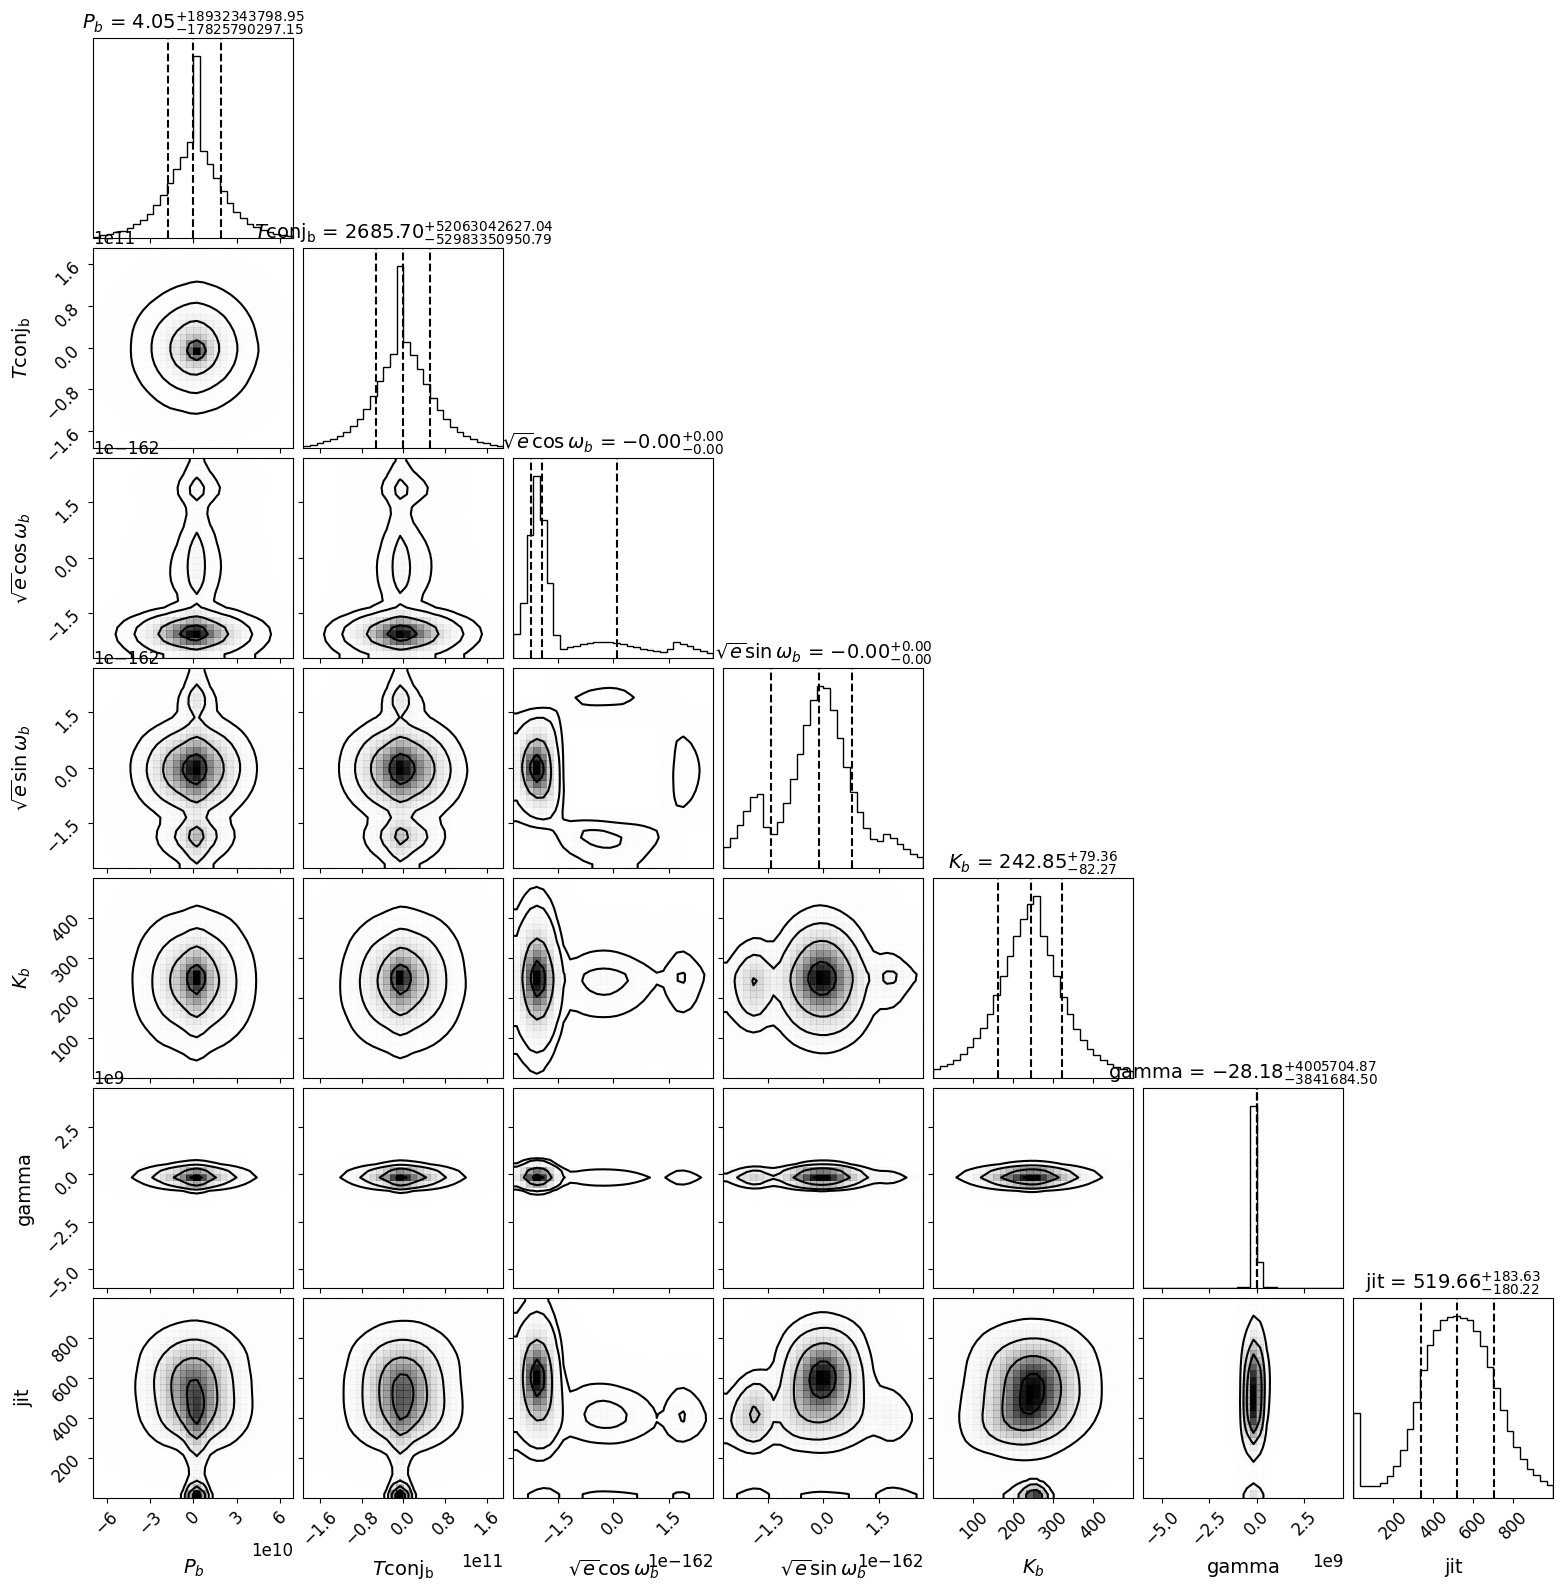

In [96]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()

In [86]:


mod.params['per1'] = radvel.Parameter(value=df['per1'].iloc[-1])

mod.params['k1'] = radvel.Parameter(value=df['k1'].iloc[-1])#amp)
mod.params['tc1'] = radvel.Parameter(value=df['tc1'].iloc[-1])#amp)

mod.params['secosw1'] = radvel.Parameter(value=df['secosw1'].iloc[-1])#amp)
mod.params['sesinw1'] = radvel.Parameter(value=df['sesinw1'].iloc[-1])#amp)


like.params['gamma'] = radvel.Parameter(value=df['gamma'].iloc[-1])
like.params['jit'] = radvel.Parameter(value=df['jit'].iloc[-1]) #np.log(np.abs(np.min(errvel)))


like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
post = radvel.posterior.Posterior(like)

print(post)
print(like.logprob())

parameter                     value      vary
per1                        3.30632       True
tc1                         2685.75       True
secosw1                           0      False
sesinw1                           0      False
k1                           245.65       True
dvdt                              0      False
curv                              0      False
gamma                      -68.2841       True
jit                         78.6939       True
tp1                         2684.93           
e1                                0           
w1                                0           

Priors
------

-106.26480456300266


(<Figure size 750x771.429 with 4 Axes>,
 [<AxesSubplot:ylabel='RV [m s$^{\\mathregular{-1}}$]'>,
  <AxesSubplot:xlabel='JD - 2457000', ylabel='Residuals'>,
  <AxesSubplot:xlabel='Phase', ylabel='RV [m s$^{\\mathregular{-1}}$]'>])

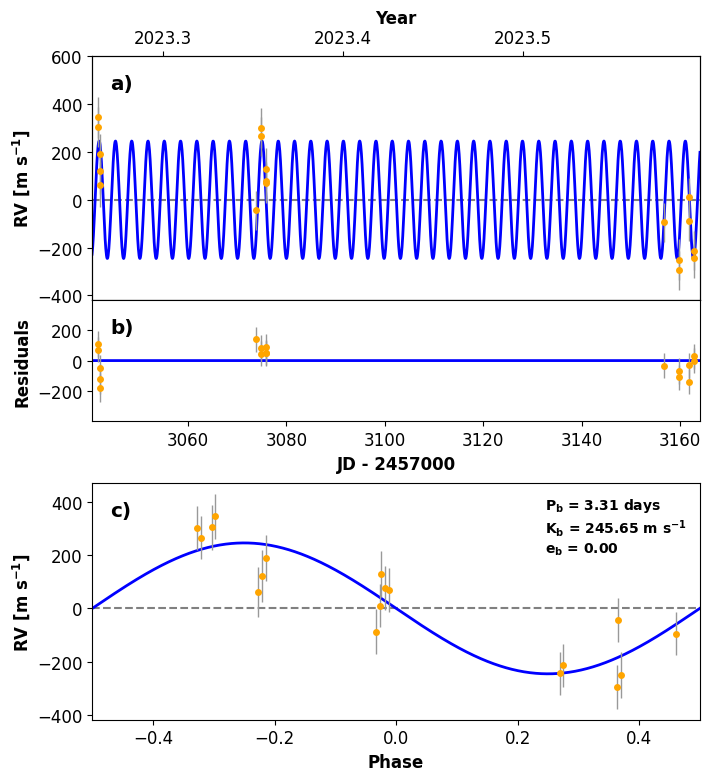

In [87]:
RVPlot = orbit_plots.MultipanelPlot(post, yscale_auto=True,epoch=2457000, nobin=True, phasetext_size='small', text_size=12,fit_linewidth=2.0,legend=False)
RVPlot.plot_multipanel()

In [88]:
m_star = 0.400962
df['e1'] = df['secosw1']**2 + df['sesinw1']**2
df['m1'] = (2*np.pi*const.G.value/(df['per1']*24*3600))**(-1/3)*df['k1']*np.sqrt(1-df['e1']**2)*((m_star*const.M_sun.value)**(2/3))
df['m1'] =  df['m1']/const.M_earth.value
df['a1'] = (const.GM_sun.value*m_star/(4.0*np.pi*np.pi)*((df['per1']*24*3600)**2))**(1/3)
df['a1'] = df['a1']/const.au.value

In [89]:
quants = df.quantile([0.159, 0.5, 0.841])

for par in post.name_vary_params():
    med = quants[par][0.5]
    high = quants[par][0.841] - med
    low = med - quants[par][0.159]
    print('{0:} : {1:1f} +{2:1f}/- {3:1f}'.format(par, med, high,low))


for par in ['e1','m1','a1']:
    med = quants[par][0.5]#dg['mb'].mode()[0]
    high = quants[par][0.841] - med
    low = med - quants[par][0.159]
    print('{0:} : {1:1f} +{2:1f}/- {3:1f}'.format(par, med, high,low))

per1 : 3.306310 +0.000424/- 0.000400
tc1 : 2685.753235 +0.004328/- 0.004333
k1 : 244.810899 +23.946348/- 24.082571
gamma : -67.659221 +17.061929/- 17.186965
jit : 85.718911 +13.911184/- 12.817659
e1 : 0.000000 +0.000000/- 0.000000
m1 : 310.120247 +30.331735/- 30.508085
a1 : 0.032028 +0.000003/- 0.000003


In [90]:
quants['m1'][0.5]*const.M_earth.value/const.M_jup.value

0.9757474178338092

In [91]:
for par in ['m1']:
    med = quants[par][0.5]#dg['mb'].mode()[0]
    high = quants[par][0.841] - med
    low = med - quants[par][0.159]
    fac = const.M_earth.value/const.M_jup.value
    print('{0:} : {1:1f} +{2:1f}/- {3:1f}'.format(par, med*fac, high*fac,low*fac))

m1 : 0.975747 +0.095434/- 0.095989
